# 可调相移光栅生成器（PNG灰度）

- 基于现有代码，支持调整周期 `period`、每步像素位移 `shift_pixels`、生成图片数量 `num_images`。
- 支持两种模式：二值光栅（binary）与正弦光栅（sine），均输出 8-bit 灰度 PNG。
- 可设置输出尺寸（`width`×`height`）、`gamma`（仅对正弦光栅生效）、以及相位对齐偏移 `phase_offset_px`（像素）。
- 支持交互式预览与批量保存。

In [1]:
# 1. 导入依赖与全局参数
import numpy as np
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from typing import List

# 交互组件
try:
    import ipywidgets as widgets
    from IPython.display import display, clear_output
    _WIDGETS_AVAILABLE = True
except Exception:
    _WIDGETS_AVAILABLE = False

# 默认参数
WIDTH = 1280
HEIGHT = 720
PERIOD = 6
SHIFT_PIXELS = 2
NUM_IMAGES = 3
GAMMA = 1.0
PHASE_OFFSET_PX = 0.0
OUTPUT_DIR = Path("new_pattern")
PREVIEW_COUNT = 3
MODE = 'binary'  # 'sine' 或 'binary'

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
print(f"输出目录: {OUTPUT_DIR.resolve()}")

输出目录: C:\localfiles\uc2dmd\src\new_pattern


In [2]:
# 2. 交互式参数控件（若 ipywidgets 可用）
if _WIDGETS_AVAILABLE:
    period_w = widgets.IntSlider(description='period', min=2, max=1024, step=1, value=PERIOD)
    shift_w = widgets.IntSlider(description='shift_pixels', min=1, max=PERIOD, step=1, value=SHIFT_PIXELS)
    num_w = widgets.IntSlider(description='num_images', min=1, max=64, step=1, value=NUM_IMAGES)
    width_w = widgets.IntText(description='width', value=WIDTH)
    height_w = widgets.IntText(description='height', value=HEIGHT)
    gamma_w = widgets.FloatSlider(description='gamma', min=0.1, max=3.0, step=0.1, value=GAMMA)
    mode_w = widgets.ToggleButtons(description='mode', options=['binary','sine'], value=MODE)
    offset_w = widgets.FloatText(description='phase_offset_px', value=PHASE_OFFSET_PX)
    outdir_w = widgets.Text(description='output_dir', value=str(OUTPUT_DIR))
    preview_w = widgets.IntSlider(description='preview_count', min=1, max=10, step=1, value=PREVIEW_COUNT)

    # 使 shift 的上限跟随 period
    def _sync_shift_range(change):
        shift_w.max = max(1, int(change['new']))
        if shift_w.value > shift_w.max:
            shift_w.value = shift_w.max
    period_w.observe(_sync_shift_range, names='value')

    # 在 binary 模式下禁用 gamma
    def _toggle_gamma(change):
        gamma_w.disabled = (mode_w.value == 'binary')
    mode_w.observe(_toggle_gamma, names='value')
    _toggle_gamma(None)

    ui = widgets.VBox([
        widgets.HBox([period_w, shift_w, num_w, preview_w]),
        widgets.HBox([width_w, height_w, gamma_w, mode_w]),
        widgets.HBox([offset_w, outdir_w])
    ])
    display(ui)
else:
    print("提示：未找到 ipywidgets。可通过 pip 安装后使用交互控件： pip install ipywidgets")

提示：未找到 ipywidgets。可通过 pip 安装后使用交互控件： pip install ipywidgets


In [3]:
# 3. 二值光栅生成函数

def generate_binary_grating(width: int, height: int, period: int) -> np.ndarray:
    if period < 2:
        raise ValueError("period 必须 ≥ 2")
    row = ((np.arange(width) % period) < (period // 2)).astype(np.uint8) * 255
    img = np.repeat(row[np.newaxis, :], height, axis=0)
    return img.astype(np.uint8)

print("已定义: generate_binary_grating()")

已定义: generate_binary_grating()


In [4]:
# 4. 正弦光栅生成函数（支持 gamma 与相位像素偏移）

def generate_sine_grating(width: int, height: int, period: int, gamma: float = 1.0, phase_offset_px: float = 0.0) -> np.ndarray:
    if period <= 0:
        raise ValueError("period 必须 > 0")
    if gamma <= 0:
        raise ValueError("gamma 必须 > 0")
    x = np.arange(width)
    base = 2 * np.pi * x / period - 2 * np.pi * (phase_offset_px / period)
    wave = 0.5 + 0.5 * np.cos(base)
    if gamma != 1.0:
        wave = np.power(wave, 1.0 / gamma)
    row = (wave * 255.0 + 0.5).astype(np.uint8)
    img = np.repeat(row[np.newaxis, :], height, axis=0)
    return img.astype(np.uint8)

print("已定义: generate_sine_grating()")

已定义: generate_sine_grating()


In [5]:
# 5. 通用位移与批量生成器

def roll_shift(img: np.ndarray, k: int, shift_pixels: int) -> np.ndarray:
    return np.roll(img, shift=k*shift_pixels, axis=1)

from typing import Literal

def generate_sequence(mode: Literal['binary','sine'], width: int, height: int, period: int,
                      num_images: int, shift_pixels: int, gamma: float = 1.0, phase_offset_px: float = 0.0):
    if mode not in ('binary','sine'):
        raise ValueError("mode 只能是 'binary' 或 'sine'")
    if width < 1 or height < 1:
        raise ValueError("width/height 必须 ≥ 1")
    if period < 2:
        raise ValueError("period 必须 ≥ 2")
    if shift_pixels < 1:
        raise ValueError("shift_pixels 必须 ≥ 1")
    if num_images < 1:
        raise ValueError("num_images 必须 ≥ 1")

    if mode == 'binary':
        base = generate_binary_grating(width, height, period)
    else:
        base = generate_sine_grating(width, height, period, gamma=gamma, phase_offset_px=phase_offset_px)

    images = [roll_shift(base, k, shift_pixels) for k in range(num_images)]
    return images

print("已定义: roll_shift(), generate_sequence()")

已定义: roll_shift(), generate_sequence()


In [6]:
# 6. PNG 灰度保存与文件命名

def save_png(arr: np.ndarray, path: Path):
    Image.fromarray(arr, mode='L').save(path, 'PNG')

def batch_save(images, output_dir: Path, mode: str, period: int, shift_pixels: int):
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    saved = []
    for idx, img in enumerate(images):
        name = f"{mode}_p{period}_s{shift_pixels}_idx{idx:02d}.png"
        p = output_dir / name
        save_png(img, p)
        saved.append(p)
        print(f"保存: {p}")
    return saved

print("已定义: save_png(), batch_save()")

已定义: save_png(), batch_save()


In [7]:
# 7. 预览若干张与水平强度剖面

def preview_images(images, period: int, preview_count: int = 3):
    n = min(preview_count, len(images))
    if n == 0:
        print("无图片可预览")
        return
    fig, axes = plt.subplots(1, n, figsize=(4*n, 3))
    if n == 1:
        axes = [axes]
    for i in range(n):
        axes[i].imshow(images[i], cmap='gray', vmin=0, vmax=255)
        axes[i].set_title(f"idx={i}")
        axes[i].axis('off')
        # 画周期刻度线
        h, w = images[i].shape
        for x in range(0, w, period):
            axes[i].axvline(x, color='yellow', alpha=0.3, linewidth=0.8)
    plt.show()

    # 水平剖面（第1张中心行）
    img0 = images[0]
    y = img0.shape[0] // 2
    profile0 = img0[y, :]
    plt.figure(figsize=(8,3))
    plt.plot(profile0, label='img[0] 中心行')
    if len(images) > 1:
        plt.plot(images[1][y, :], label='img[1] 中心行')
    if len(images) > 2:
        plt.plot(images[2][y, :], label='img[2] 中心行')
    for x in range(0, img0.shape[1], period):
        plt.axvline(x, color='gray', alpha=0.2)
    plt.legend()
    plt.tight_layout()
    plt.show()

print("已定义: preview_images()")

已定义: preview_images()


In [8]:
# 8. 参数校验、生成、保存与交互动作

def validate_params(width, height, period, shift_pixels, num_images, mode, gamma):
    if width < 1 or height < 1:
        raise ValueError("width/height 必须 ≥ 1")
    if period < 2:
        raise ValueError("period 必须 ≥ 2")
    if shift_pixels < 1:
        raise ValueError("shift_pixels 必须 ≥ 1")
    if num_images < 1:
        raise ValueError("num_images 必须 ≥ 1")
    if mode == 'sine' and gamma <= 0:
        raise ValueError("正弦模式下 gamma 必须 > 0")
    if shift_pixels % period == 0:
        print("提示：shift_pixels 是 period 的倍数，所有图片将完全相同。")


def run_generate_and_preview(width=WIDTH, height=HEIGHT, period=PERIOD, num_images=NUM_IMAGES, shift_pixels=SHIFT_PIXELS,
                              mode=MODE, gamma=GAMMA, phase_offset_px=PHASE_OFFSET_PX, output_dir=OUTPUT_DIR, preview_count=PREVIEW_COUNT):
    validate_params(width, height, period, shift_pixels, num_images, mode, gamma)
    imgs = generate_sequence(mode, width, height, period, num_images, shift_pixels, gamma, phase_offset_px)
    preview_images(imgs, period, preview_count)
    return imgs


def run_save(images, output_dir=OUTPUT_DIR, mode=MODE, period=PERIOD, shift_pixels=SHIFT_PIXELS):
    return batch_save(images, Path(output_dir), mode, period, shift_pixels)

# 若 widgets 可用，绑定按钮
actions = {}
if _WIDGETS_AVAILABLE:
    btn_preview = widgets.Button(description='预览 Preview')
    btn_save = widgets.Button(description='保存 Save PNGs')
    out = widgets.Output()

    def _on_preview(_):
        with out:
            clear_output(wait=True)
            try:
                imgs = run_generate_and_preview(
                    width=width_w.value,
                    height=height_w.value,
                    period=period_w.value,
                    num_images=num_w.value,
                    shift_pixels=shift_w.value,
                    mode=mode_w.value,
                    gamma=gamma_w.value,
                    phase_offset_px=offset_w.value,
                    output_dir=outdir_w.value,
                    preview_count=preview_w.value,
                )
                actions['last_images'] = imgs
            except Exception as e:
                print("错误:", e)

    def _on_save(_):
        with out:
            clear_output(wait=True)
            try:
                imgs = actions.get('last_images')
                if imgs is None:
                    print("请先点击预览以生成图片，再保存。")
                    return
                saved = run_save(
                    images=imgs,
                    output_dir=outdir_w.value,
                    mode=mode_w.value,
                    period=period_w.value,
                    shift_pixels=shift_w.value
                )
                print(f"共保存 {len(saved)} 张。")
            except Exception as e:
                print("错误:", e)

    btn_preview.on_click(_on_preview)
    btn_save.on_click(_on_save)
    display(widgets.HBox([btn_preview, btn_save]))
    display(out)
else:
    print("若需交互控件，请安装 ipywidgets；否则可直接调用 run_generate_and_preview()/run_save()。")

若需交互控件，请安装 ipywidgets；否则可直接调用 run_generate_and_preview()/run_save()。


## 使用说明（无小部件环境）

- 直接运行下一代码单元，按默认参数生成并预览；修改调用参数以自定义。
- 例如：生成 6 张、周期 6、每步平移 1 像素的正弦光栅，并保存到 `new_pattern`。

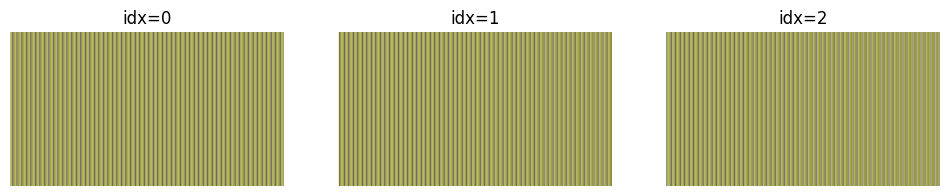

C:\Users\workh\AppData\Local\Temp\ipykernel_9076\1770140134.py:34: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\workh\AppData\Local\Temp\ipykernel_9076\1770140134.py:34: UserWarning: Glyph 24515 (\N{CJK UNIFIED IDEOGRAPH-5FC3}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\workh\AppData\Local\Temp\ipykernel_9076\1770140134.py:34: UserWarning: Glyph 34892 (\N{CJK UNIFIED IDEOGRAPH-884C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\localfiles\uc2dmd\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\localfiles\uc2dmd\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24515 (\N{CJK UNIFIED IDEOGRAPH-5FC3}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\localfiles\uc2dmd\.venv\Lib\site-pa

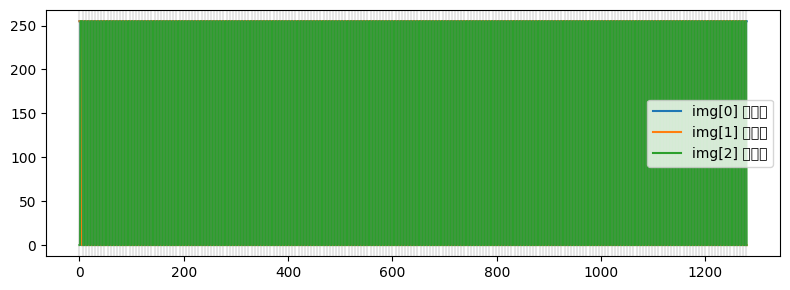

保存: new_pattern\binary_p6_s2_idx00.png
保存: new_pattern\binary_p6_s2_idx01.png
保存: new_pattern\binary_p6_s2_idx02.png


C:\Users\workh\AppData\Local\Temp\ipykernel_9076\1934679625.py:4: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(arr, mode='L').save(path, 'PNG')


In [9]:
# 非交互环境下的一键生成/保存示例
imgs = run_generate_and_preview(width=WIDTH, height=HEIGHT, period=PERIOD,
                                num_images=NUM_IMAGES, shift_pixels=SHIFT_PIXELS,
                                mode=MODE, gamma=GAMMA, phase_offset_px=PHASE_OFFSET_PX,
                                output_dir=OUTPUT_DIR, preview_count=PREVIEW_COUNT)
_ = run_save(imgs, output_dir=OUTPUT_DIR, mode=MODE, period=PERIOD, shift_pixels=SHIFT_PIXELS)